![IDAL](https://i.imgur.com/tIKXIG1.jpg)  

#**Máster en Inteligencia Artificial Avanzada y Aplicada:  IA^3**
---

# CNNs con CIFAR
El conjunto de datos <a href='https://en.wikipedia.org/wiki/CIFAR-10'>CIFAR-10</a> es similar a MNIST, salvo que en lugar de un canal de color (escala de grises) hay tres canales (RGB).<br>
Mientras que una imagen MNIST tiene un tamaño de (1,28,28), las imágenes CIFAR son de (3,32,32). Hay 10 categorías en las que puede clasificarse una imagen:
0. avión
1. automóvil
2. pájaro
3. gato
4. ciervo
5. perro
6. rana
7. caballo
8. barco
9. camión

Al igual que con el código anterior, asegúrate de ver las clases teóricas. Debes tener claros los conceptos:
* capas convolucionales
* filtros/kernels
* pooling
* profundidad/canales, stride y zero-padding

## Importaciones


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sn  # for heatmaps
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

## Carga del dataset CIFAR-10
PyTorch pone a disposición los conjuntos de datos de entrenamiento y prueba de CIFAR-10 a través de  <a href='https://pytorch.org/docs/stable/torchvision/index.html'><tt><strong>torchvision</strong></tt></a>. La primera vez que es llamado, el dataset es descargado en el equipo local, al directorio especificado. Desde entonces, torchvision siempre busca una copia local, antes de descargar los datos.

En notebooks anteriores ya trabajamos las tranformaciones, tamaño de batch y el <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader'><tt><strong>DataLoader</strong></tt></a>.

In [2]:
transform = transforms.ToTensor()

train_data = datasets.CIFAR10(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='../Data', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:08<00:00, 19971831.94it/s]


Extracting ../Data/cifar-10-python.tar.gz to ../Data
Files already downloaded and verified


In [3]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

### Creamos los loaders (*cargadores* de datos)


In [5]:
torch.manual_seed(101)  # for reproducible results

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

### Definimos nombres para las etiquetas
Podemos llamar a las etiquetas como queramos, siempre que aparezcan en el orden de 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'. Aquí vamos a utilizar etiquetas de 5 caracteres **en inglés** rellenadas con espacios para que los informes queden alineados más tarde.

In [6]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

No queremos usar el nombre de variable "class" aquí, ya que sobrescribiría la palabra clave incorporada de Python.

## Vsta de un lote de imagenes

Label: [    1     5     8     1     6     1     6     3     7     9]
Class:    car   dog  ship   car  frog   car  frog   cat horse truck


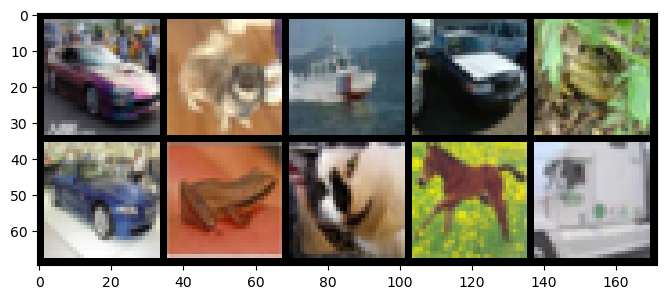

In [7]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

# Grab the first batch of 10 images
for images,labels in train_loader:
    break

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

# Print the images
im = make_grid(images, nrow=5)  # the default nrow is 8
plt.figure(figsize=(8,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Definimos el modelo
En la sección anterior utilizamos dos capas convolucionales y dos capas de pooling antes de alimentar los datos a través de una capa oculta totalmente conectada (FC) hasta nuestra salida. La arquitetura es CONV/RELU/POOL/CONV/RELU/POOL/FC/RELU/FC. Usaremos esa misma configuración ahora, con pequeños cambios.

Estos cambios son:
* tenemos imágenes de 3 canales de entrada en lugar de 1
* hay que ajustar el nuevo tamaño de la capa totalmente conectada<br>

Nuestra primera capa convolucional tendrá 3 canales de entrada, 6 canales de salida, un tamaño de kernel de 3 (lo que resulta en un filtro 3x3) y una longitud de paso (stride) de 1 píxel.<br> Todo esto se define como <tt>nn.Conv2d(3,6,3,1)</tt>

In [8]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)  # changed from (1, 6, 5, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(6*6*16, 120)   # changed from (4*4*16) to fit 32x32 images with 3x3 filters
        self.fc2 = nn.Linear(120,84) 
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 6*6*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

<div class="alert alert-info"><strong>¿Porque <tt>(6x6x16)</tt> en lugar de <tt>(5x5x16)</tt>?</strong><br>
Con MNIST los kernels y las capas de agrupación dieron como resultado $\;(((28-2)/2)-2)/2=5,5 \;$ lo que redondea a 5 píxeles por lado.<br>
Con CIFAR el resultado es $\;(((32-2)/2)-2)/2 = 6.5\;$ lo que redondea a 6 píxeles por lado.</div>

In [9]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Incluyendo el bias para cada capa, el número total de parámetros entrenables que va a tener la red es:<br>

$\quad\begin{split}(3\times6\times3\times3)+6+(6\times16\times3\times3)+16+(576\times120)+120+(120\times84)+84+(84\times10)+10 &=\\
162+6+864+16+69120+120+10080+84+840+10 &= 81,302\end{split}$<br>

In [10]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [11]:
count_parameters(model)

   162
     6
   864
    16
 69120
   120
 10080
    84
   840
    10
______
 81302


## Definimos función de pérdida y optimizador

---



In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Entrenamos el modelo
Los datos son suministrados directamente al modelo sin necesidad de "flattening"
<div class="alert alert-info"><font color=blue><strong>OPCIONAL: </strong>En caso de que el entrenamiento dure demasiado tiempo, puede interrumpir el núcleo, saltar al final del cuaderno y cargar una versión entrenada del modelo que se haya guardado en esta carpeta.</font></div>

In [13]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1

        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # Update parameters
        optimizer.zero_grad() #Limpiar gradientes
        loss.backward() # Calcular gradientes ("diferencia" entre lo que el modelo ha predicho y las labels verdadesras) 
        optimizer.step() # Actualizar los parámetros del modelo (El optimizador tiene como input los parámetros del modelo)

        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch: 1000 [ 10000/50000]  loss: 1.76048017  accuracy:  24.300%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 2.26761198  accuracy:  30.675%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 1.39935267  accuracy:  34.573%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 1.74994314  accuracy:  37.428%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 0.88264245  accuracy:  39.834%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 1.43162918  accuracy:  50.570%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 1.26412487  accuracy:  51.585%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 1.46647000  accuracy:  52.247%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 1.10860550  accuracy:  52.648%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 0.98433572  accuracy:  52.838%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 1.22199178  accuracy:  56.440%
epoch:  2  batch: 2000 [ 20000/50000]  loss: 0.95568150  accuracy:  56.655%
epoch:  2  batch: 3000 [ 30000/50000]  loss: 1.14302993  accuracy:  56.683%
epoch:  2  b

## Opcional: Salvamos el modelo
Esto guardará el modelo recién entrenado, sin sobrescribir el modelo guardado que hemos proporcionado llamado <strong>CIFAR10-CNN-Model-master.pt</strong>

In [14]:
torch.save(model.state_dict(), 'CIFAR10-CNN-Model.pt')

## Graficamos pérdida (loss) y precision (accuracy) para comparar

In [15]:
# Atención! train_losses es una lista de tensores con Autograd activado
train_losses

[tensor(0.8826, grad_fn=<NllLossBackward0>),
 tensor(0.9843, grad_fn=<NllLossBackward0>),
 tensor(1.0103, grad_fn=<NllLossBackward0>),
 tensor(1.1786, grad_fn=<NllLossBackward0>),
 tensor(2.1117, grad_fn=<NllLossBackward0>),
 tensor(0.9146, grad_fn=<NllLossBackward0>),
 tensor(0.7102, grad_fn=<NllLossBackward0>),
 tensor(0.8474, grad_fn=<NllLossBackward0>),
 tensor(0.5347, grad_fn=<NllLossBackward0>),
 tensor(0.5294, grad_fn=<NllLossBackward0>)]

In [16]:
# Hay que pasarlo a lista de tensores numpy para plotear
train_losses_np= [ loss.detach().numpy() for loss in train_losses]

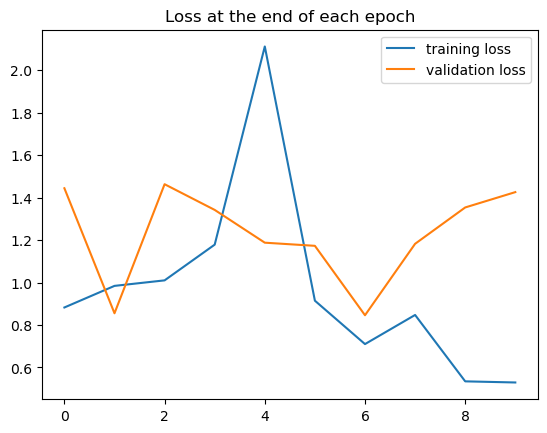

In [17]:
plt.plot(train_losses_np, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

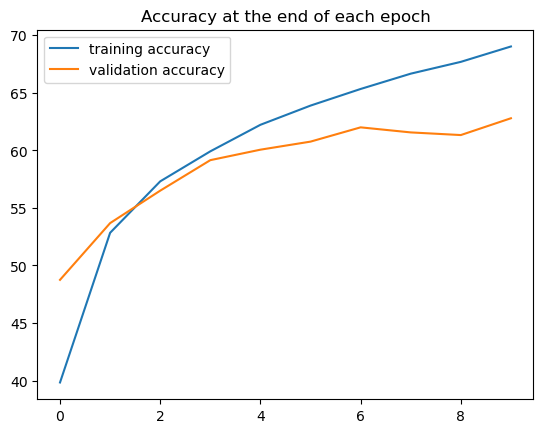

In [18]:
plt.plot([t/500 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

## Evaluamos Test Data

In [19]:
print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # print the most recent result as a percent

[tensor(4875), tensor(5368), tensor(5650), tensor(5915), tensor(6006), tensor(6076), tensor(6200), tensor(6156), tensor(6133), tensor(6279)]

Test accuracy: 62.790%


El resultado obtenido no es tan impresionante como con MNIST, lo cual tiene sentido. Tendríamos que ajustar nuestros parámetros para obtener mejores resultados.<br>
Aun así, es mucho mejor que el 10% que obtendríamos con el azar.

## Visualizamos la matriz de confusión

Para comparar las predicciones con la realidad, tenemos que pasar todo el conjunto de pruebas por el modelo.
Además, dado que nuestro modelo no fue tan preciso como con MNIST, utilizaremos un <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>heatmap</a> para visualizar mejor los resultados.

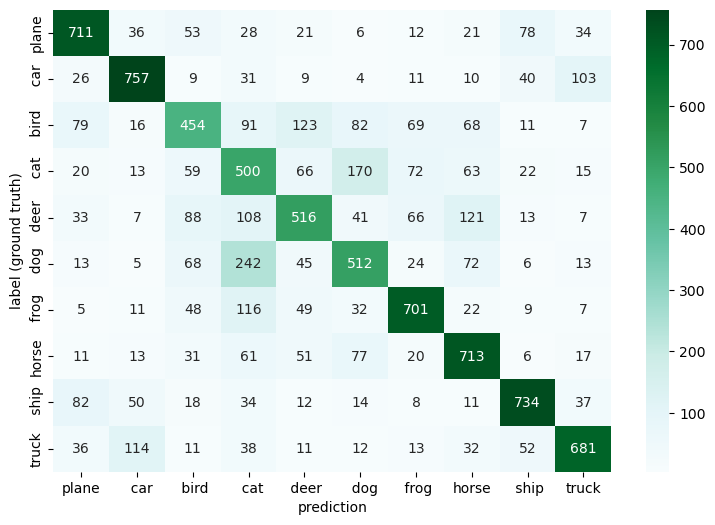

In [20]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

## Examinamos los fallos
Podemos seguir los índices de las predicciones fallidas, y extraer la correspondiente imagen y etiqueta. Lo haremos en batches para ahorrar espacio en la pantalla

In [21]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')

# Display the number of misses
len(misses)

3721

In [22]:
# Display the first 8 index positions
misses[:8]

array([    4,     7,     9,    15,    16,    17,    24,    27])

In [23]:
# Set up an iterator to feed batched rows
r = 8   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Hemos configurado un iterador (row) y ahora podemos lanzar y relanzar la celda siguiente para ir moviendonos por todas las predicciones fallidas.
<br>
Puedes usar <kbd>Ctrl+Enter</kbd> para mantenerte en la misma celda entre ejecuciones. Verás un <tt>StopIteration</tt> una vez que todos los fallos hayan sido mostrados.

Index: [   28    30    31    35    36    37    40    42]
Label: [    9     6     5     2     4     1     4     5]
Class:  truck  frog   dog  bird  deer   car  deer   dog

Guess: [    3     3     3     3     7     9     0     3]
Class:    cat   cat   cat   cat horse truck plane   cat


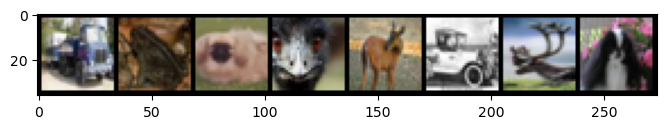

In [25]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

nextrow = next(row)
lbls = y_test.index_select(0,torch.tensor(nextrow)).numpy()
gues = predicted.index_select(0,torch.tensor(nextrow)).numpy()
print("Index:", nextrow)
print("Label:", lbls)
print("Class: ", *np.array([class_names[i] for i in lbls]))
print()
print("Guess:", gues)
print("Class: ", *np.array([class_names[i] for i in gues]))

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(8,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

<div class="alert alert-info"><font color=blue><h2>Opcional: Cargar un modelo salvado (y entrenado)</h2>
En caso de que el entrenamiento de la Convolutional Network lleve demasiado tiempo, podemos cargar una versión entrenada ejecutando el siguiente código:</font>
<pre style='background-color:rgb(217,237,247)'>
model2 = ConvolutionalNetwork()
model2.load_state_dict(torch.load('CIFAR10-CNN-Model-master.pt'))
model2.eval()</pre>
</div>

In [26]:
# Instantiate the model and load saved parameters
model2 = ConvolutionalNetwork()
#model2.load_state_dict(torch.load('CIFAR10-CNN-Model.pt'))          # El nuestro previamente guardado
model2.load_state_dict(torch.load('CIFAR10-CNN-Model-master.pt'))   # El suministrado
model2.eval()

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [27]:
# Evaluate the saved model against the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model2(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 6105/10000 =  61.050%


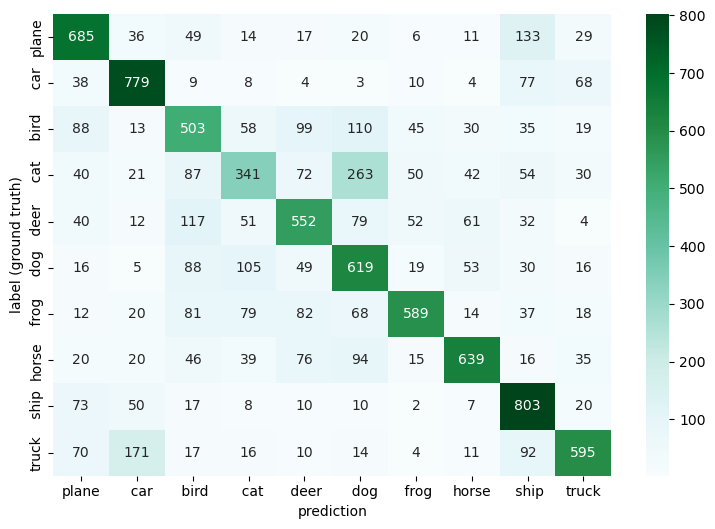

In [28]:
# Display the confusion matrix as a heatmap
arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

## Fin del Notebook

Referencias y modelos empleados para el Notebook:

*   Documentación de [Pytorch](https://pytorch.org/docs/stable/index.html)
*   [PyTorch Tutorial for Deep Learning Researchers](https://github.com/yunjey/pytorch-tutorial) by Yunjey Choi
*   [FastAI](https://www.fast.ai/) development notebooks by Jeremy Howard.
*   Documentación y cursos en [Pierian Data](https://www.pieriandata.com/)
* Matriz de confusión: <a href='https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html'>scikit-learn's confusion_matrix</a>
+ Gráficos: <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps</a>, and <a href='https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html'>matplotlib colormaps</a>.